# Downloading the Kaggle Dataset

In [2]:
! kaggle datasets download andrewmvd/face-mask-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
License(s): CC0-1.0
... resuming from 268435456 bytes (148532627 bytes left) ...




 64%|######4   | 256M/398M [00:00<?, ?B/s]
 65%|######4   | 257M/398M [00:01<03:49, 643kB/s]
 65%|######4   | 258M/398M [00:01<01:52, 1.30MB/s]
 65%|######5   | 259M/398M [00:01<01:08, 2.11MB/s]
 66%|######5   | 261M/398M [00:02<00:35, 4.03MB/s]
 66%|######5   | 262M/398M [00:02<00:33, 4.28MB/s]
 66%|######6   | 263M/398M [00:02<00:32, 4.28MB/s]
 67%|######6   | 265M/398M [00:02<00:23, 6.04MB/s]
 67%|######6   | 266M/398M [00:03<00:25, 5.34MB/s]
 67%|######7   | 267M/398M [00:03<00:26, 5.24MB/s]
 67%|######7   | 268M/398M [00:03<00:24, 5.54MB/s]
 68%|######7   | 269M/398M [00:03<00:26, 5.06MB/s]
 68%|######7   | 270M/398M [00:03<00:25, 5.26MB/s]
 68%|######8   | 271M/398M [00:04<00:27, 4.86MB/s]
 68%|######8   | 272M/398M [00:04<00:28, 4.61MB/s]
 69%|######8   | 273M/398M [00:04<00:27, 4.83MB/s]
 69%|######8   | 274M/398M [00:04<00:28, 4.58MB/s]
 69%|######9   | 275M/398M [00:04<00:25, 5.00MB/s]
 69%|######9   | 276M/398M [00:05<00:24, 5.17MB/s]
 70%|######9   | 277M/398M [00:05<00:23

In [3]:
# Unzipping the Dataset
import zipfile

with zipfile.ZipFile('face-mask-detection.zip', 'r') as zip_re:
    zip_re.extractall('face-mask-detection')

# Importing the Libraries

In [34]:
import xml.etree.ElementTree as ET
import os
import shutil
from sklearn.model_selection import train_test_split
import random
import ultralytics
from ultralytics import YOLO
from PIL import Image
import cv2
import matplotlib.pyplot as plt


# Converting the XML Annotations to YOLO Format

In [5]:
# Defining directories Location
xml_dir = "face-mask-detection/annotations/"
yolo_dir = "face-mask-detection/labels"

In [6]:
os.makedirs(yolo_dir, exist_ok=True) # creating new directories if doesn't exist already

In [7]:
# mapping the labels
class_mapping = {
    "without_mask":0,
    "with_mask":1,
    "mask_worn_incorrectly":2
}

In [8]:
# Function to conver xml to yolo format
def convert_xml_to_yolo(xml_file, yolo_file, image_width, image_hight):
  tree = ET.parse(xml_file)
  root = tree.getroot()

  yolo_annotations = []
  for obj in root.findall("object"):
    class_name = obj.find("name").text

    if class_name not in class_mapping:
      continue
    class_id = class_mapping[class_name]

    x_min = int(obj.find("bndbox/xmin").text)
    y_min = int(obj.find("bndbox/ymin").text)
    x_max = int(obj.find("bndbox/xmax").text)
    y_max = int(obj.find("bndbox/ymax").text)

    x_center = ((x_min + x_max) / 2) / image_width
    y_center = ((y_min + y_max) / 2) / image_height
    box_width = (x_max - x_min) / image_width
    box_height = (y_max - y_min) / image_height

    yolo_annotations.append(f"{class_id} {x_center} {y_center} {box_width} {box_height}")

    with open(yolo_file, "w") as f:
      f.write("\n".join(yolo_annotations))

In [9]:
# Running the loop to convert all the labels
for xml_file in os.listdir(xml_dir):
  if xml_file.endswith(".xml"):
    xml_path = os.path.join(xml_dir, xml_file)

    tree = ET.parse(xml_path)
    root = tree.getroot()

    image_width = int(root.find("size/width").text)
    image_height = int(root.find("size/height").text)

    yolo_file = os.path.join(yolo_dir, xml_file.replace(".xml", ".txt")
    )
    convert_xml_to_yolo(xml_path, yolo_file, image_width, image_height)

print("Conversion Completed! Yolo annotations saved in: ",yolo_dir)

Conversion Completed! Yolo annotations saved in:  face-mask-detection/labels


# Spliting the Dataset between Train, Validation and Test set

In [13]:
# Define the paths
dataset_dir = 'face-mask-detection/'
train_dir = 'face-mask-detection/train'
test_dir = 'face-mask-detection/test'
val_dir = 'face-mask-detection/val'

dataset_path = 'face-mask-detection/'
output_path = 'face-mask-detection/'

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Paths for images and labels
images_path = os.path.join(dataset_path, 'images')
labels_path = os.path.join(dataset_path, 'labels')

# Gather all image and label pairs
images = sorted([img for img in os.listdir(images_path) if img.endswith(('.jpg', '.png'))])
labels = sorted([lbl for lbl in os.listdir(labels_path) if lbl.endswith('.txt')])

# Ensure images and labels match
images_labels = list(zip(images, labels))
random.shuffle(images_labels)  # Shuffle data for random splits

# Split data
train_data, temp_data = train_test_split(images_labels, test_size=(val_ratio + test_ratio))
val_data, test_data = train_test_split(temp_data, test_size=test_ratio / (val_ratio + test_ratio))

# Define a function to copy data to designated folders
def copy_data(data, split_name):
    os.makedirs(os.path.join(output_path, split_name, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_path, split_name, 'labels'), exist_ok=True)
    for img_file, lbl_file in data:
        shutil.copy(os.path.join(images_path, img_file), os.path.join(output_path, split_name, 'images', img_file))
        shutil.copy(os.path.join(labels_path, lbl_file), os.path.join(output_path, split_name, 'labels', lbl_file))

# Copy data to train, val, and test directories
copy_data(train_data, 'train')
copy_data(val_data, 'val')
copy_data(test_data, 'test')

print("Dataset split into train, val, and test folders successfully!")


Dataset split into train, val, and test folders successfully!


#### Checking for ultralytics

In [15]:
ultralytics.checks()

Ultralytics 8.3.23  Python-3.12.4 torch-2.5.0+cpu CPU (Intel Core(TM) i5-8250U 1.60GHz)
Setup complete  (8 CPUs, 7.9 GB RAM, 124.5/476.9 GB disk)


# Creating the Data.yaml file

In [19]:
# Sample data to be written to the YAML file
import yaml
data = {
    'train': 'face-mask-detection/train',                   # train images path
    'val': 'face-mask-detection/val',                       # validation images path
    'test': 'face-mask-detection/test',                     # test images path
    'nc': 3,                                    # number of classes
    'names': ["without_mask","with_mask","mask_worn_incorrectly"] # class names
}
# Specify the file name
file_name = 'data.yaml'

# Write the data to the YAML file
with open(file_name, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

print(f"{file_name} created successfully!")

data.yaml created successfully!


# Training the Yolo11 Model

In [ ]:
model = YOLO("yolo11n.pt")  # Load a pretrained model
results = model.train(data="data.yaml", epochs=100, imgsz=640)

Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/face-mask-detection/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

100%|██████████| 755k/755k [00:00<00:00, 103MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/face-mask-detection/train/labels... 526 images, 240 backgrounds, 0 corrupt: 100%|██████████| 766/766 [00:01<00:00, 737.21it/s]

train: New cache created: /content/face-mask-detection/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/face-mask-detection/val/labels... 48 images, 183 backgrounds, 0 corrupt: 100%|██████████| 231/231 [00:00<00:00, 466.40it/s]

val: New cache created: /content/face-mask-detection/val/labels.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.75G      1.678      3.061      1.341         39        640: 100%|██████████| 48/48 [00:28<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]

                   all        231        233     0.0028      0.497     0.0653     0.0373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.85G      1.406      1.952      1.119         97        640: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


                   all        231        233      0.087      0.163     0.0479     0.0189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.68G      1.319       1.69      1.101         44        640: 100%|██████████| 48/48 [00:24<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.70it/s]

                   all        231        233      0.196      0.456      0.162     0.0969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.48G      1.278      1.603      1.086        127        640: 100%|██████████| 48/48 [00:24<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        231        233      0.223      0.544      0.195        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.61G      1.287       1.47      1.073         64        640: 100%|██████████| 48/48 [00:22<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]

                   all        231        233      0.205      0.657      0.195      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       2.6G      1.223      1.352      1.068         63        640: 100%|██████████| 48/48 [00:25<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

                   all        231        233      0.236      0.659      0.219      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.61G      1.226      1.355      1.078         37        640: 100%|██████████| 48/48 [00:23<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.03it/s]

                   all        231        233      0.198      0.642       0.18      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.81G      1.206      1.218       1.05         89        640: 100%|██████████| 48/48 [00:25<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.90it/s]

                   all        231        233       0.25      0.524      0.211      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.42G      1.232      1.243      1.057         60        640: 100%|██████████| 48/48 [00:23<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


                   all        231        233       0.19      0.702      0.201      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.65G      1.189      1.148      1.028         78        640: 100%|██████████| 48/48 [00:24<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]

                   all        231        233      0.203      0.743       0.19      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.57G      1.158      1.115      1.026         74        640: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


                   all        231        233      0.259      0.702      0.238      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.47G      1.169      1.123       1.04         94        640: 100%|██████████| 48/48 [00:22<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

                   all        231        233      0.213      0.751       0.22      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.55G      1.175      1.041      1.024         81        640: 100%|██████████| 48/48 [00:24<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]

                   all        231        233      0.185      0.773      0.194       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.56G      1.146      1.053      1.027         82        640: 100%|██████████| 48/48 [00:22<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]

                   all        231        233      0.204       0.72      0.209       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.52G      1.144      1.064      1.018         40        640: 100%|██████████| 48/48 [00:25<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]

                   all        231        233      0.194      0.645      0.207      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.58G      1.153      1.056       1.01        111        640: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.47it/s]

                   all        231        233      0.245      0.571      0.225      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.66G      1.156      1.068      1.026         67        640: 100%|██████████| 48/48 [00:25<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]

                   all        231        233      0.223      0.718      0.207      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.67G      1.148      1.057      1.013         34        640: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        231        233      0.219       0.64      0.222      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.59G      1.117      1.023      1.019         60        640: 100%|██████████| 48/48 [00:22<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]

                   all        231        233      0.225       0.73      0.229      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.63G      1.123      1.014      1.011         89        640: 100%|██████████| 48/48 [00:24<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]

                   all        231        233      0.222      0.715      0.217      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.77G      1.139      1.006      1.002         57        640: 100%|██████████| 48/48 [00:22<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

                   all        231        233      0.212      0.629      0.206      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.65G      1.088      1.032     0.9918        100        640: 100%|██████████| 48/48 [00:24<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        231        233      0.212      0.717      0.217      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.96G      1.114      1.016      0.991         39        640: 100%|██████████| 48/48 [00:23<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]

                   all        231        233      0.192      0.755      0.188      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.47G       1.08     0.9854      0.996        114        640: 100%|██████████| 48/48 [00:25<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

                   all        231        233        0.2      0.795      0.212      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.61G      1.104     0.9444     0.9987         67        640: 100%|██████████| 48/48 [00:23<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        231        233      0.211      0.696      0.194      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       2.6G      1.098     0.9577     0.9925         63        640: 100%|██████████| 48/48 [00:24<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]

                   all        231        233      0.187      0.775      0.214      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.41G      1.124     0.9514      1.008         57        640: 100%|██████████| 48/48 [00:24<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]

                   all        231        233      0.219      0.678       0.21      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.54G      1.053     0.9284     0.9821         56        640: 100%|██████████| 48/48 [00:22<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]

                   all        231        233       0.23      0.693      0.223      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.74G      1.075     0.9311     0.9819        117        640: 100%|██████████| 48/48 [00:27<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.91it/s]

                   all        231        233        0.2      0.733      0.195      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.68G      1.068     0.9352     0.9819         93        640: 100%|██████████| 48/48 [00:22<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.23it/s]

                   all        231        233      0.195      0.822       0.19      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.56G      1.052     0.9104      0.983         62        640: 100%|██████████| 48/48 [00:24<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        231        233      0.201      0.798      0.218      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.56G      1.066     0.8953     0.9798         61        640: 100%|██████████| 48/48 [00:22<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]

                   all        231        233      0.196      0.803      0.199      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.51G      1.039     0.8812      0.973        117        640: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

                   all        231        233      0.199      0.689      0.181      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.65G      1.055     0.9075     0.9813         68        640: 100%|██████████| 48/48 [00:24<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]

                   all        231        233      0.197      0.736      0.184      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.56G      1.046     0.8925     0.9793         72        640: 100%|██████████| 48/48 [00:23<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

                   all        231        233      0.195      0.753      0.187       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.66G      1.037     0.8732     0.9753        160        640: 100%|██████████| 48/48 [00:25<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]

                   all        231        233      0.195      0.723      0.188      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.56G      1.044     0.8972     0.9702         70        640: 100%|██████████| 48/48 [00:23<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

                   all        231        233      0.197      0.813      0.188      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.69G      1.043     0.8749      0.966         82        640: 100%|██████████| 48/48 [00:24<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

                   all        231        233      0.181      0.758       0.18      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.76G      1.028     0.8487     0.9681        107        640: 100%|██████████| 48/48 [00:22<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]

                   all        231        233       0.17      0.747      0.172      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.66G      1.031     0.8694     0.9754         89        640: 100%|██████████| 48/48 [00:23<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]

                   all        231        233      0.194      0.807      0.188      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.69G      1.042     0.8627     0.9767        118        640: 100%|██████████| 48/48 [00:24<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]

                   all        231        233      0.199      0.797      0.187      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.54G     0.9986     0.8273     0.9622         44        640: 100%|██████████| 48/48 [00:22<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.84it/s]

                   all        231        233      0.188       0.77      0.178      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       2.6G      1.031     0.8161     0.9638        127        640: 100%|██████████| 48/48 [00:26<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.85it/s]

                   all        231        233      0.181      0.766       0.17      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.47G      1.012     0.8135      0.959         82        640: 100%|██████████| 48/48 [00:22<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

                   all        231        233      0.174      0.612      0.156      0.098



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.67G      1.006     0.8642     0.9657         74        640: 100%|██████████| 48/48 [00:24<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

                   all        231        233      0.159      0.648      0.151     0.0901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.77G      1.034     0.8367     0.9633         96        640: 100%|██████████| 48/48 [00:24<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]

                   all        231        233      0.183      0.701      0.168      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.71G      1.014     0.8214     0.9705         32        640: 100%|██████████| 48/48 [00:22<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]

                   all        231        233      0.174      0.736      0.164      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.65G      1.006     0.7964     0.9591         57        640: 100%|██████████| 48/48 [00:25<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]

                   all        231        233      0.158       0.58      0.136     0.0854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.62G      1.023     0.8094     0.9609         71        640: 100%|██████████| 48/48 [00:23<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]

                   all        231        233      0.167      0.701      0.146      0.092



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.82G     0.9938     0.7861      0.948         69        640: 100%|██████████| 48/48 [00:25<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]

                   all        231        233      0.168      0.557      0.149     0.0937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.55G     0.9929     0.7993      0.966         60        640: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        231        233      0.178      0.658      0.167       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.49G     0.9904     0.7819     0.9576         51        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.90it/s]

                   all        231        233      0.168      0.646      0.158      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.63G     0.9736     0.7597     0.9518         76        640: 100%|██████████| 48/48 [00:24<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


                   all        231        233      0.171       0.71      0.159     0.0973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.48G     0.9875     0.7704     0.9491        122        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]

                   all        231        233       0.16      0.577      0.147     0.0967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.49G     0.9914     0.7675     0.9499         51        640: 100%|██████████| 48/48 [00:25<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]

                   all        231        233      0.178      0.611      0.147     0.0926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.63G     0.9793     0.7524     0.9465         86        640: 100%|██████████| 48/48 [00:23<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]

                   all        231        233      0.136      0.559      0.122     0.0789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.64G     0.9922     0.7872     0.9529        105        640: 100%|██████████| 48/48 [00:25<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.83it/s]

                   all        231        233      0.165      0.681      0.146     0.0912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.67G     0.9644     0.7427     0.9482         46        640: 100%|██████████| 48/48 [00:23<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

                   all        231        233       0.15      0.621      0.138     0.0871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.84G     0.9988     0.7258     0.9552         78        640: 100%|██████████| 48/48 [00:22<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.03it/s]

                   all        231        233      0.162      0.624      0.144      0.091



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.72G     0.9499     0.7516     0.9549        163        640: 100%|██████████| 48/48 [00:24<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all        231        233      0.138      0.552      0.121     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.62G     0.9782     0.7339     0.9447         63        640: 100%|██████████| 48/48 [00:22<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

                   all        231        233      0.144      0.539      0.123     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.69G     0.9657     0.7043     0.9519         58        640: 100%|██████████| 48/48 [00:27<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]

                   all        231        233      0.135      0.531      0.111     0.0735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.55G     0.9409     0.7414     0.9413        117        640: 100%|██████████| 48/48 [00:23<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

                   all        231        233      0.155      0.504       0.13     0.0827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.98G     0.9731     0.7239      0.949         60        640: 100%|██████████| 48/48 [00:25<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

                   all        231        233       0.14      0.529      0.127     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.57G     0.9483     0.7078     0.9384         66        640: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.45it/s]

                   all        231        233      0.155       0.51      0.115     0.0739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.64G     0.9564     0.7143     0.9453         58        640: 100%|██████████| 48/48 [00:24<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

                   all        231        233      0.149      0.374      0.106     0.0676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.55G     0.9214     0.7084     0.9336         40        640: 100%|██████████| 48/48 [00:22<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        231        233      0.147      0.482      0.118     0.0768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.67G     0.9501     0.7118     0.9411        131        640: 100%|██████████| 48/48 [00:22<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]

                   all        231        233      0.146      0.532      0.122     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       2.5G     0.9308     0.6661     0.9372         95        640: 100%|██████████| 48/48 [00:24<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all        231        233      0.116      0.405       0.11     0.0719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.49G     0.9371      0.694     0.9411         92        640: 100%|██████████| 48/48 [00:23<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.91it/s]

                   all        231        233      0.122      0.472      0.108     0.0688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.69G     0.9666      0.691     0.9376         72        640: 100%|██████████| 48/48 [00:25<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]

                   all        231        233      0.143      0.611      0.121     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.68G     0.9304     0.6856      0.935        106        640: 100%|██████████| 48/48 [00:23<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.85it/s]

                   all        231        233      0.165      0.683      0.148     0.0965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.48G     0.9304     0.6655     0.9379         86        640: 100%|██████████| 48/48 [00:25<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]

                   all        231        233      0.141       0.54      0.122     0.0782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.63G     0.9336     0.6727     0.9299         56        640: 100%|██████████| 48/48 [00:22<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]

                   all        231        233      0.122      0.502      0.114     0.0729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       2.5G     0.8987     0.6503     0.9263         54        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.70it/s]

                   all        231        233      0.142      0.556      0.122     0.0752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.55G     0.9065     0.6266     0.9262         45        640: 100%|██████████| 48/48 [00:23<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]

                   all        231        233      0.127      0.529      0.112     0.0717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.53G      0.917     0.6567     0.9371         36        640: 100%|██████████| 48/48 [00:23<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]

                   all        231        233      0.127       0.47      0.105     0.0668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.74G     0.9162     0.6315      0.926         72        640: 100%|██████████| 48/48 [00:24<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        231        233      0.129      0.445      0.101     0.0647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.65G     0.9134     0.6207     0.9217         93        640: 100%|██████████| 48/48 [00:22<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.71it/s]

                   all        231        233      0.136      0.446      0.111     0.0731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.62G     0.9143     0.6168      0.928        105        640: 100%|██████████| 48/48 [00:24<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.83it/s]

                   all        231        233      0.129      0.417      0.106       0.07



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.79G      0.916     0.6404     0.9325         48        640: 100%|██████████| 48/48 [00:22<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

                   all        231        233      0.154      0.523      0.125     0.0809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.71G     0.9124     0.6053     0.9188        122        640: 100%|██████████| 48/48 [00:22<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

                   all        231        233      0.133      0.482      0.102     0.0666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.58G     0.9374     0.6257     0.9235         49        640: 100%|██████████| 48/48 [00:24<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        231        233      0.109      0.423     0.0817     0.0535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.49G     0.8972     0.6031     0.9228         64        640: 100%|██████████| 48/48 [00:23<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]

                   all        231        233      0.124      0.472        0.1      0.064



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.76G     0.8958     0.6088     0.9227         87        640: 100%|██████████| 48/48 [00:24<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]

                   all        231        233      0.129      0.507      0.109     0.0693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.57G     0.8902     0.5887     0.9236         56        640: 100%|██████████| 48/48 [00:22<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]

                   all        231        233      0.117      0.458     0.0918     0.0603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.77G     0.8987     0.5845     0.9122         97        640: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

                   all        231        233       0.11       0.44     0.0909     0.0584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.74G     0.9034      0.589     0.9185         74        640: 100%|██████████| 48/48 [00:24<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        231        233      0.113      0.425      0.089      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.67G     0.8684     0.5833     0.9166         69        640: 100%|██████████| 48/48 [00:22<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]

                   all        231        233      0.106      0.409     0.0905     0.0592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.56G     0.8951     0.5796     0.9172         84        640: 100%|██████████| 48/48 [00:24<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]

                   all        231        233      0.117       0.45     0.0899     0.0584


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.65G     0.8765     0.5674     0.9127         43        640: 100%|██████████| 48/48 [00:24<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.64it/s]

                   all        231        233      0.109      0.387     0.0867     0.0545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       2.6G     0.8512     0.5434     0.9017         24        640: 100%|██████████| 48/48 [00:24<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

                   all        231        233      0.111      0.447     0.0921     0.0595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       2.6G     0.8623     0.5203     0.9091         45        640: 100%|██████████| 48/48 [00:22<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]

                   all        231        233      0.114       0.42     0.0857     0.0552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.62G     0.8494     0.4948     0.8976         30        640: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

                   all        231        233      0.109      0.428     0.0832     0.0538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.59G     0.8417     0.4976     0.9013         47        640: 100%|██████████| 48/48 [00:22<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        231        233      0.108      0.315     0.0734     0.0482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.52G     0.8388     0.4928     0.8976         21        640: 100%|██████████| 48/48 [00:23<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]

                   all        231        233      0.101       0.31     0.0642     0.0431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.55G       0.82     0.4768     0.8959         27        640: 100%|██████████| 48/48 [00:23<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]

                   all        231        233      0.101      0.313     0.0684     0.0457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.68G     0.8318     0.4721     0.8983         42        640: 100%|██████████| 48/48 [00:22<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]

                   all        231        233      0.104       0.31     0.0696     0.0464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.64G     0.8102     0.4705     0.8885         33        640: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        231        233      0.101      0.308     0.0643     0.0429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.54G      0.831     0.4827     0.8964         30        640: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

                   all        231        233     0.0995      0.318     0.0663     0.0441



100 epochs completed in 0.821 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 5.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


                   all        231        233      0.259      0.702      0.237      0.139
          without_mask         16         34      0.301      0.559      0.242      0.129
             with_mask         46        199      0.217      0.844      0.231      0.148
Speed: 0.6ms preprocess, 4.1ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/detect/train3


# Loading the Trained Model

In [16]:
new_model = YOLO("weights/last.pt")
import yaml

# Model Performance Evaluation and Training Results"

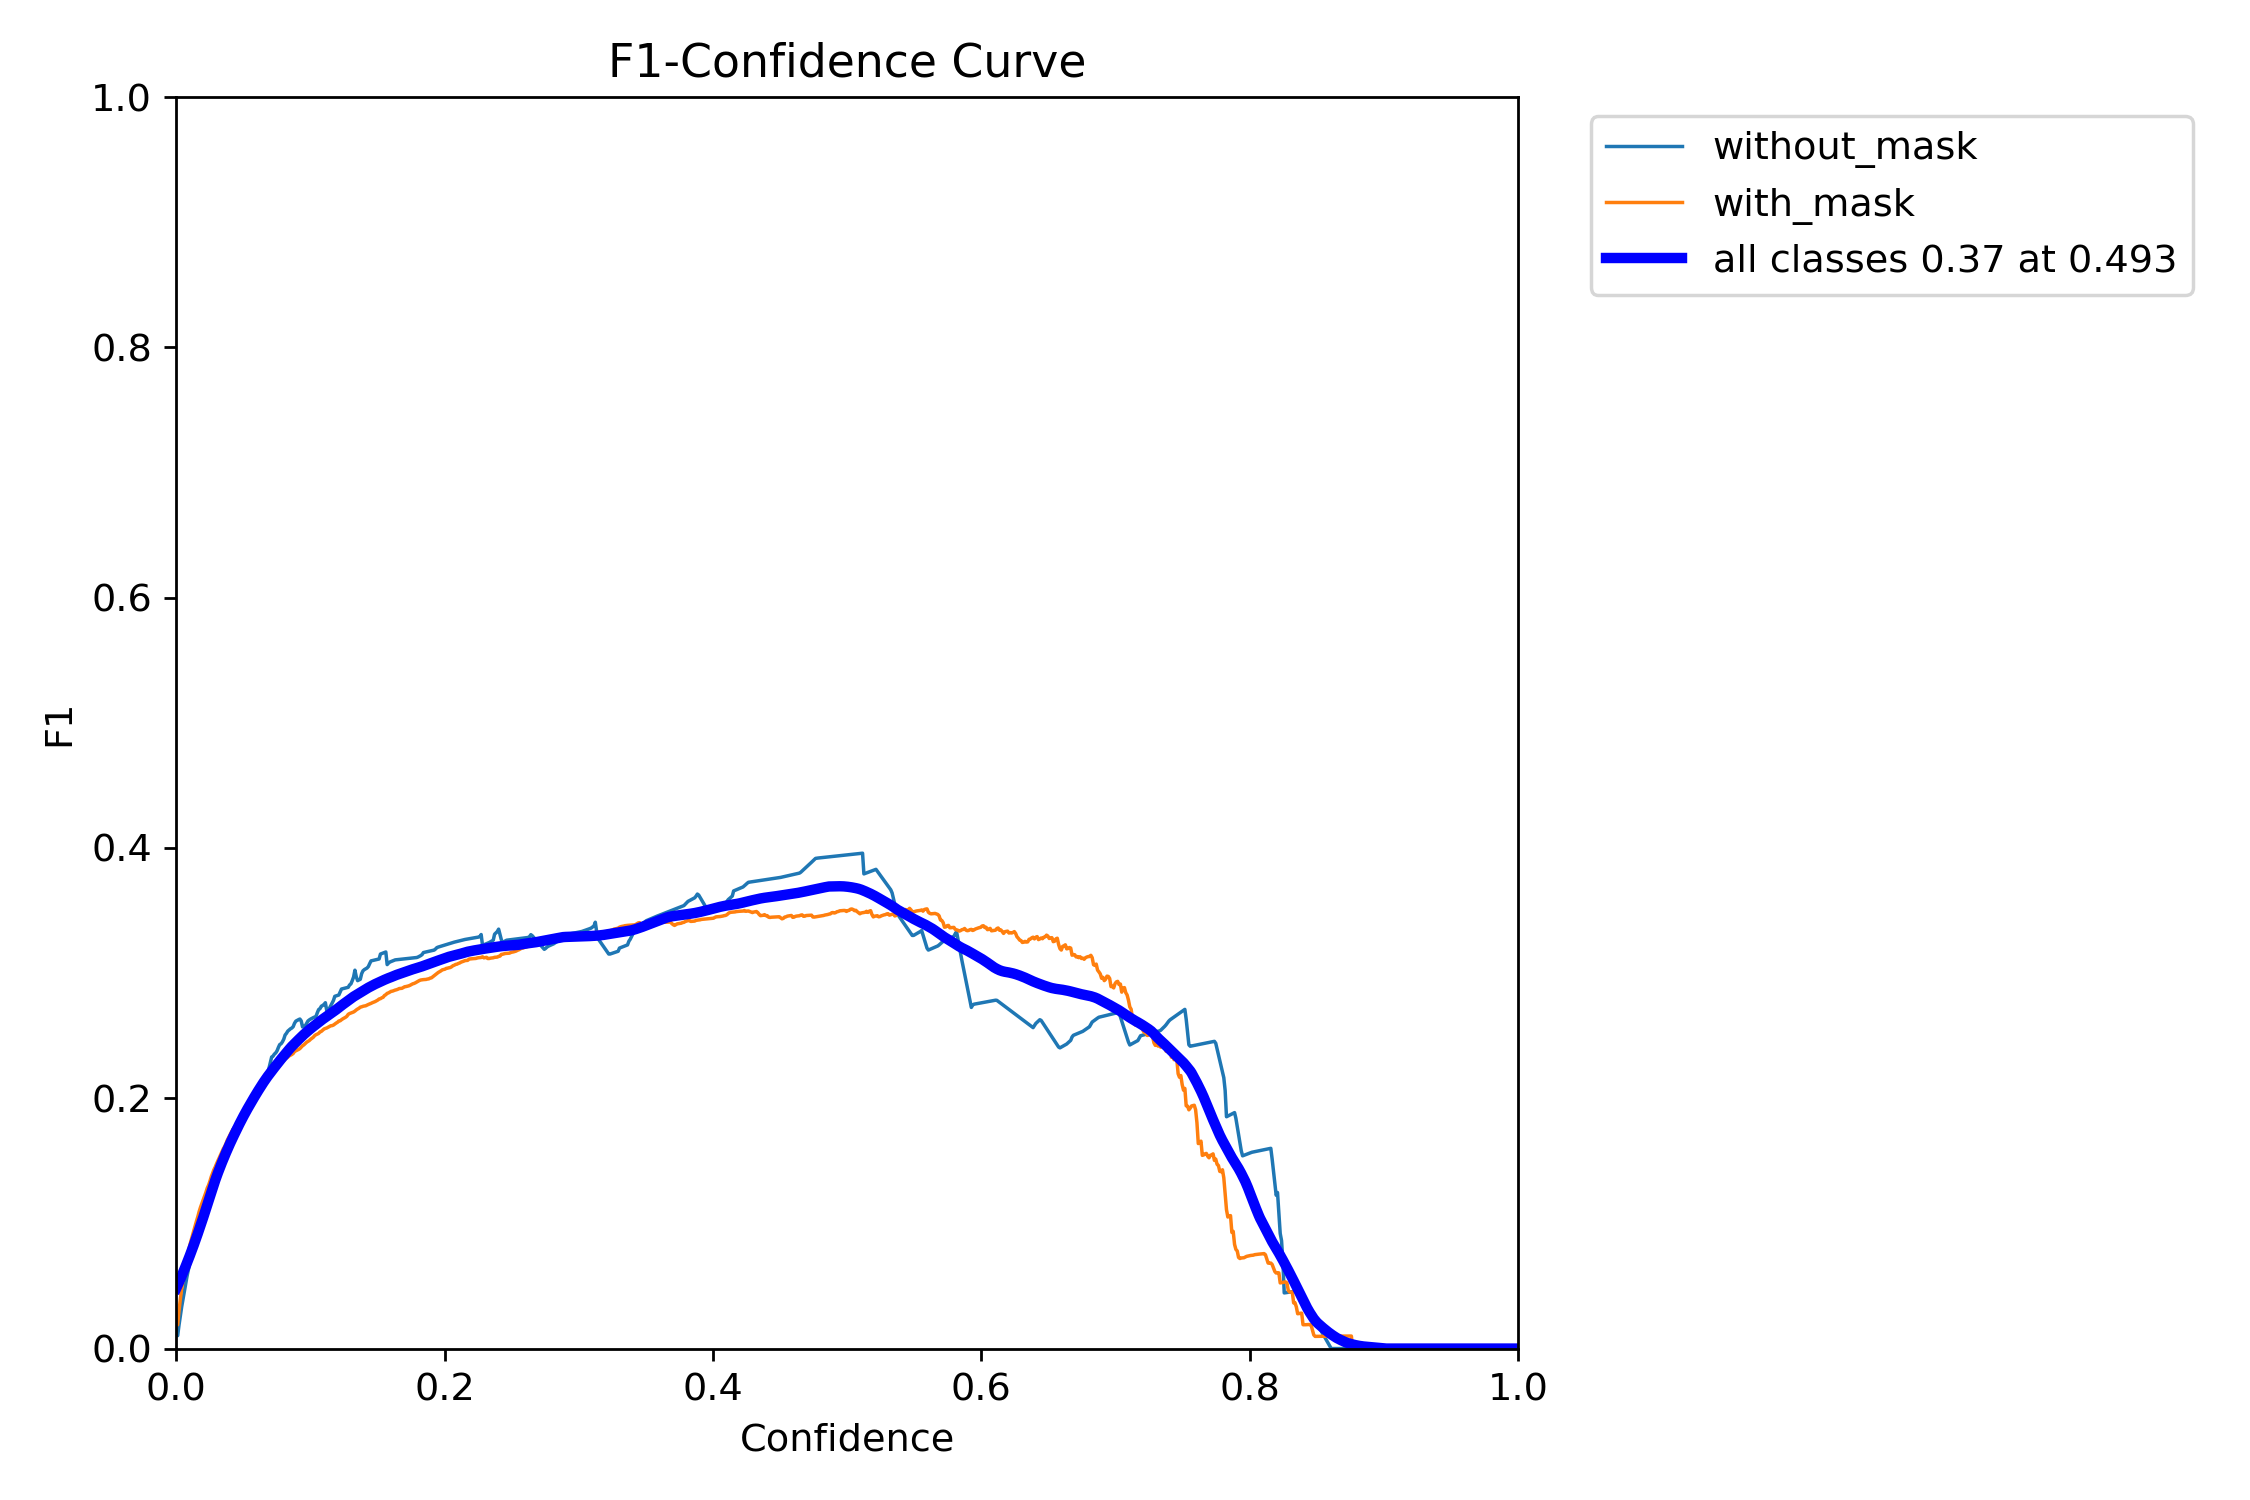

In [36]:
Image.open("runs/detect/train3/F1_curve.png")

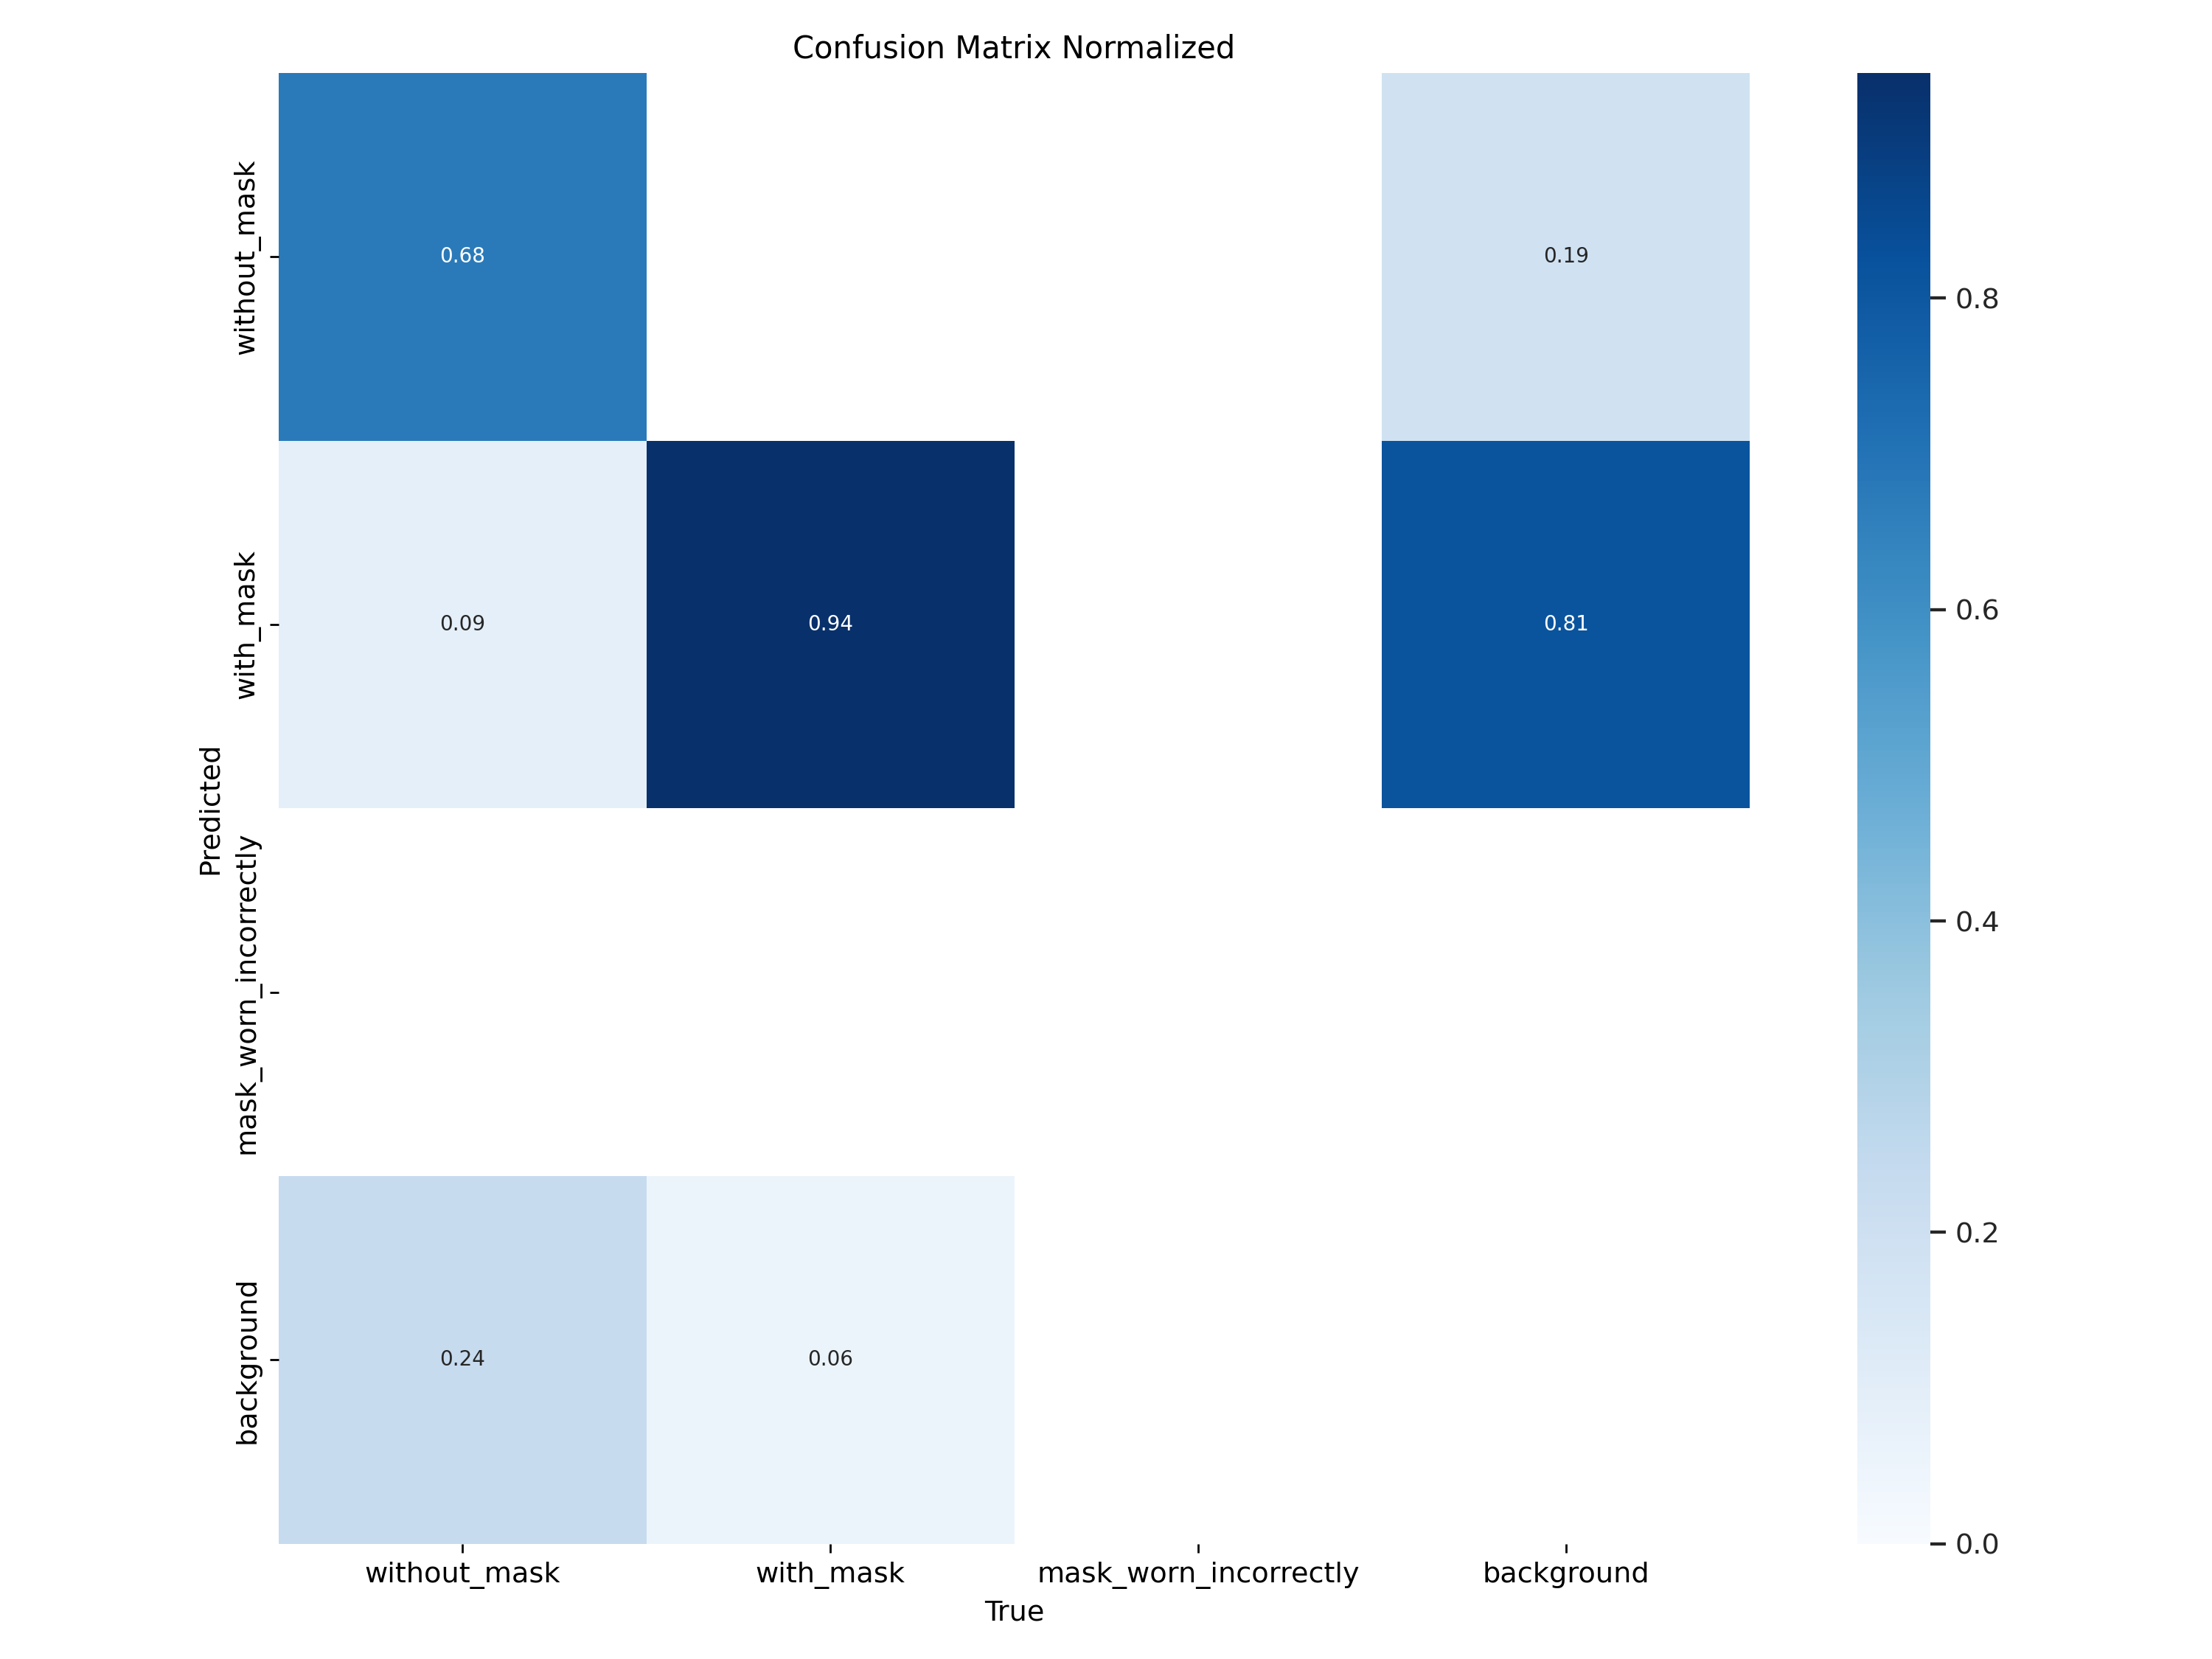

In [39]:
Image.open("runs/detect/train3/confusion_matrix_normalized.png")

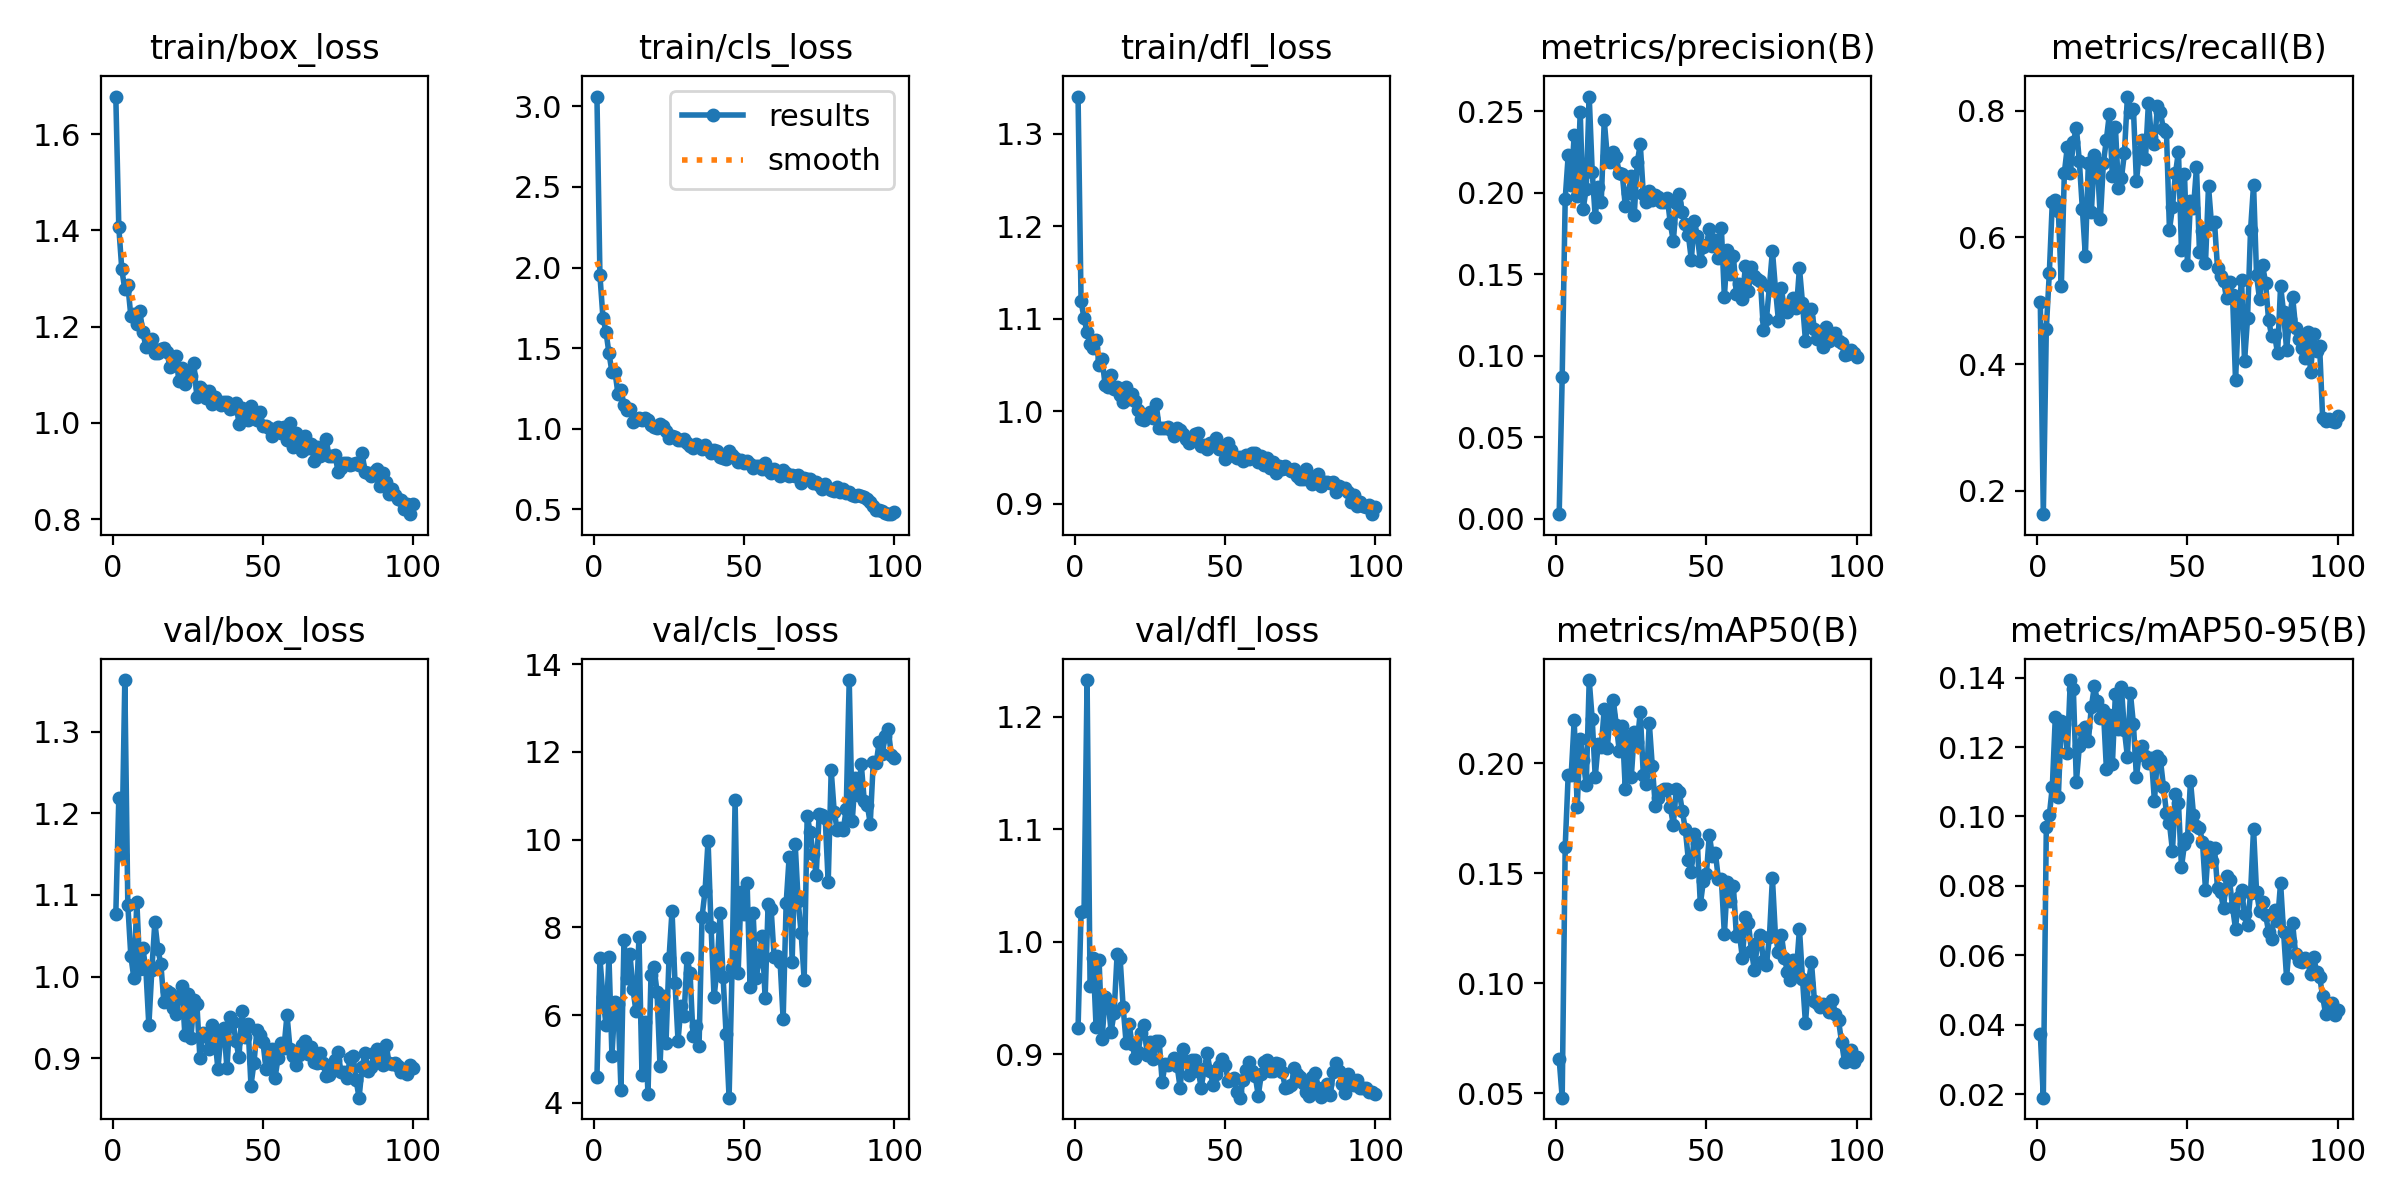

In [40]:
Image.open("runs/detect/train3/results.png")